In [1]:
%matplotlib inline

## Model Inference

Here we show how to load a model for inference

In [2]:
import torch as pt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Models trained with `prehsept` can be loaded as torch script modules:

In [3]:
model = pt.jit.load('../models/gpdk180/nmos-20220902-092231/trace.pt')

For comparison we will load the training data:

In [4]:
df = pd.DataFrame( pt.load('../data/gpdk180-nmos.pt').numpy()
                 , columns =  [ 'vg', 'W', 'L', 'M', 'temp'
                              , 'M0:pwr', 'M0:region', 'M0:vgs', 'M0:vds', 'M0:vbs', 'M0:vth'
                              , 'M0:vdsat', 'M0:gm', 'M0:gds', 'M0:gmbs', 'M0:betaeff'
                              , 'M0:cgg', 'M0:cgd', 'M0:cgs', 'M0:cgb'
                              , 'M0:cdg', 'M0:cdd', 'M0:cds', 'M0:cdb'
                              , 'M0:csg', 'M0:csd', 'M0:css', 'M0:csb'
                              , 'M0:cbg', 'M0:cbd', 'M0:cbs', 'M0:cbb'
                              , 'M0:ron', 'M0:id', 'M0:gmoverid', 'M0:self_gain', 'M0:rout'
                              , 'M0:fug', 'M0:vearly', 'D', 'G', 'S', 'B'
                              , 'VB:p', 'VD:p', 'VG:p', 'VS:p' ])

We'll choose a random width ($W$) and length ($L$) from the dataset:

In [5]:
W   = np.random.choice(df.W.unique())
L   = np.random.choice(df.L.unique())
Vdd = np.max(np.abs(df['M0:vds']))

In [6]:
Vbs = round(df['M0:vbs'], ndigits = 2)
Vgs = round(df['M0:vgs'], ndigits = 2)
Vds = round(df['M0:vds'], ndigits = 2)

In [7]:
traces = df[ (df.W == W) & (df.L == L )
           & (df['M0:vbs'] == 0.0) 
           & (df['M0:vds'] == (Vdd / 2.0)) 
           ][['M0:gmoverid', 'M0:fug', 'M0:vds', 'M0:vbs'
             , 'M0:id', 'W', 'L', 'M0:gm', 'M0:gds', 'M0:vgs' ]]

Next we will get the model inputs from the trace as torch tensor:

In [8]:
x = pt.from_numpy(traces[['M0:gmoverid', 'M0:fug', 'M0:vds', 'M0:vbs']].values)

... and feed it through the model

In [9]:
y = model(x)

Now we extract the results and compare them with the original data:

In [10]:
true_gmoverid = (traces['M0:gmoverid']).values
true_idoverw  = (traces['M0:id'] / traces['W']).values
true_gdsoverw = (traces['M0:gds'] / traces['W']).values
true_L        = traces['L'].values

pred_gmoverid = x[:,0].numpy()
pred_idoverw  = y[:,0].numpy()
pred_gdsoverw = y[:,2].numpy()
pred_L_       = y[:,1].numpy()

L_μ           = np.mean(pred_L_)
L_σ           = np.std(pred_L_)
L_hi          = df.L.max()
L_lo          = df.L.min()
pred_L        = np.repeat(L_μ, true_L.size)

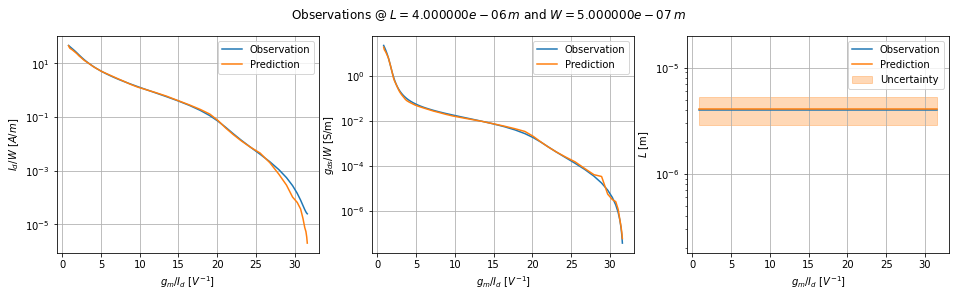

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16,4))
fig.suptitle(f'Observations @ $L = {L:2e}\,m$ and $W = {W:2e}\,m$')
ax1.plot(true_gmoverid, true_idoverw, label = 'Observation')
ax1.plot(true_gmoverid, pred_idoverw, label = "Prediction")
ax1.set_xlabel("$g_{m} / I_{d} ~ [V^{-1}]$")
ax1.set_ylabel("$I_{d} / W ~ [A/m]$")
ax1.set_yscale("log")
ax1.legend()
ax1.grid("on")
ax2.plot(true_gmoverid, true_gdsoverw, label = "Observation")
ax2.plot(true_gmoverid, pred_gdsoverw, label = "Prediction")
ax2.set_xlabel("$g_{m} / I_{d} ~ [V^{-1}]$")
ax2.set_ylabel("$g_{ds} / W$ [S/m]")
ax2.set_yscale("log")
ax2.legend()
ax2.grid("on")
ax3.plot(true_gmoverid, true_L, label = "Observation")
ax3.plot(true_gmoverid, pred_L, label = "Prediction")
ax3.fill_between( true_gmoverid, (pred_L + (3 * L_σ)), (pred_L - (3 * L_σ))
                , alpha = 0.3, color = "tab:orange", label = "Uncertainty")
ax3.ticklabel_format(axis = 'both', style = 'sci', scilimits = (-2,2))
ax3.set_xlabel("$g_{m} / I_{d} ~ [V^{-1}]$")
ax3.set_ylabel("$L$ [m]")
ax3.set_ylim(L_lo, L_hi)
ax3.set_yscale("log")
ax3.legend()
ax3.grid("on")